In [1]:
import pandas as pd

In [2]:
# Load the datasets
file_paths = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx"
}

# Load each dataset into a dictionary of DataFrames
dataframes = {name: pd.ExcelFile(path).parse(sheet_name=0) for name, path in file_paths.items()}

# Display basic info about each dataset
dataset_info = {
    name: {
        "Shape": df.shape,
        "Columns": df.columns.tolist(),
        "Missing Values": df.isnull().sum().to_dict()
    }
    for name, df in dataframes.items()
}

In [3]:
dataframes

{'b2b_gv':             data_valanda      0    1       2      3      4      5       6  \
 0    2022-11-01 00:00:00  0.000  0.0   4.680  0.001  0.000  0.000  1.7159   
 1    2022-11-01 01:00:00  0.000  0.0   4.340  0.001  0.000  0.000  1.0673   
 2    2022-11-01 02:00:00  0.000  0.0   4.120  0.000  0.000  0.000  1.3911   
 3    2022-11-01 03:00:00  0.000  0.0   4.160  0.002  0.000  0.000  1.4227   
 4    2022-11-01 04:00:00  0.000  0.0   4.520  0.001  0.000  0.000  1.0054   
 ...                  ...    ...  ...     ...    ...    ...    ...     ...   
 8755 2023-10-31 20:00:00  5.958  0.0  12.174  0.001  0.042  0.111  1.7820   
 8756 2023-10-31 21:00:00  6.209  0.0  11.889  0.000  0.041  0.102  1.3011   
 8757 2023-10-31 22:00:00  5.947  0.0  11.998  0.002  0.049  0.109  1.3996   
 8758 2023-10-31 23:00:00  4.463  0.0  11.846  0.001  0.049  0.119  1.6896   
 8759 2023-11-01 00:00:00  4.699  0.0  11.992  0.001  0.046  0.109  1.1057   
 
            7       8  ...     753     754     755  

In [4]:
# Extract relevant columns for timestamp and hourly consumption
processed_preview = {}

for name, df in dataframes.items():
    try:
        # Identify the timestamp column and hourly consumption columns
        if "data_valanda" in df.columns:
            timestamp_col = "data_valanda"
        elif "dateTime" in df.columns:
            timestamp_col = "dateTime"
        else:
            raise ValueError("Timestamp column not found")

        # Keep only the timestamp and hourly consumption columns
        consumption_cols = [col for col in df.columns if str(col).isdigit()]  # Hourly columns are numeric
        relevant_cols = [timestamp_col] + consumption_cols
        processed_preview[name] = df[relevant_cols].head()  # Limit to the first few rows for preview

        # Rename the timestamp column to standardize
        processed_preview[name].rename(columns={timestamp_col: "timestamp"}, inplace=True)
    except Exception as e:
        processed_preview[name] = f"Error processing {name}: {e}"

# Split the data into training and test sets by cutting out the last 24 hours
split_data = {}

for name, df in processed_preview.items():
    try:
        if isinstance(df, pd.DataFrame):
            # Ensure the data is sorted by timestamp
            df = df.sort_values("timestamp")
            
            # Split into training and test sets
            train_data = df.iloc[:-24]  # All except last 24 rows
            test_data = df.iloc[-24:]  # Last 24 rows
            
            split_data[name] = {
                "train": train_data,
                "test": test_data
            }
        else:
            split_data[name] = {"Error": df}
    except Exception as e:
        split_data[name] = {"Error": str(e)}

# Summarize training and test set sizes
split_summary = {
    name: {
        "Training Rows": len(data["train"]) if "train" in data else "Error",
        "Test Rows": len(data["test"]) if "test" in data else "Error",
        "Columns": data["train"].columns.tolist() if "train" in data else str(data)
    }
    for name, data in split_data.items()
}

In [5]:
# Debugging and fixing the preprocessing issue
def preprocess_and_engineer_features_fixed(train, test):
    """
    Perform data preprocessing and feature engineering on the training and test datasets with fixed handling of lag features.
    """
    # Make a copy to avoid modifying the original data
    train = train.copy()
    test = test.copy()

    # Handle missing values: Fill with zero or forward-fill (based on domain knowledge)
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    # Convert timestamp to datetime for feature engineering
    for df in [train, test]:
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Create time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month

    # Lag features: Include values from the previous day (D-1) if sufficient data exists
    for col in train.columns[1:]:  # Exclude timestamp column
        train[f"{col}_lag1"] = train[col].shift(24)
        if len(train) >= 24:
            test[f"{col}_lag1"] = train[col].iloc[-24:].values  # Use last 24-hour lag values for test

    # Rolling mean features: Calculate rolling averages only if there is sufficient data
    for col in train.columns[1:]:  # Exclude timestamp column
        if len(train) >= 24 * 7:  # Check for sufficient data
            train[f"{col}_rolling7"] = train[col].rolling(window=24 * 7).mean()
            test[f"{col}_rolling7"] = train[col].iloc[-24 * 7:].mean()  # Use last 7-day mean for test

    # Drop rows with NaN values generated by rolling or shifting in the train set
    train.dropna(inplace=True)

    return train, test


# Apply preprocessing and feature engineering to all datasets with fixes
preprocessed_data_fixed = {}

for name, data in split_data.items():
    try:
        if "train" in data and "test" in data:
            train, test = preprocess_and_engineer_features_fixed(data["train"], data["test"])
            preprocessed_data_fixed[name] = {
                "train": train,
                "test": test
            }
    except Exception as e:
        preprocessed_data_fixed[name] = {"Error": str(e)}

# Summarize preprocessing results after fixes
preprocessed_summary_fixed = {
    name: {
        "Training Rows": len(data["train"]) if "train" in data else "Error",
        "Test Rows": len(data["test"]) if "test" in data else "Error",
        "Columns": data["train"].columns.tolist() if "train" in data else str(data)
    }
    for name, data in preprocessed_data_fixed.items()
}



C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\1983801807.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f"{col}_lag1"] = train[col].shift(24)
C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\1983801807.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f"{col}_lag1"] = train[col].shift(24)
C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\1983801807.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np



# Correcting column handling and retrying the model training
def train_and_evaluate_models_fixed(train, test, target_col_prefix=""):
    """
    Train and evaluate Random Forest, Linear Regression, and SVM models with corrected column handling.
    """
    try:
        # Ensure all column names are strings
        train.columns = train.columns.map(str)
        test.columns = test.columns.map(str)

        # Separate features (X) and target (y)
        feature_cols = [col for col in train.columns if col != "timestamp" and not col.startswith(target_col_prefix)]
        target_cols = [col for col in train.columns if col.startswith(target_col_prefix)]

        if not feature_cols or not target_cols:
            raise ValueError("Features or target columns are missing.")

        X_train, y_train = train[feature_cols], train[target_cols[0]]
        X_test, y_test = test[feature_cols], test[target_cols[0]]

        if X_train.empty or X_test.empty:
            raise ValueError("Training or test features are empty.")

        # Initialize models
        models = {
            "Random Forest": RandomForestRegressor(random_state=42),
            "Linear Regression": LinearRegression(),
            "SVM": SVR(kernel='rbf')
        }

        results = {}

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Evaluate the model
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            results[model_name] = {"MAE": mae, "MAPE": mape}

        return results

    except Exception as e:
        return {"Error": str(e)}


# Apply fixed training and evaluation to all datasets
model_results_fixed = {}

for name, data in preprocessed_data_fixed.items():
    if "train" in data and "test" in data:
        model_results_fixed[name] = train_and_evaluate_models_fixed(data["train"], data["test"], target_col_prefix="0")

# Summarize fixed results
results_summary_fixed = {}

for dataset, results in model_results_fixed.items():
    if isinstance(results, dict):
        for model_key, metrics in results.items():
            if isinstance(metrics, dict):
                results_summary_fixed[f"{dataset}_{model_key}"] = metrics

results_df_fixed = pd.DataFrame(results_summary_fixed).T
# tools.display_dataframe_to_user(name="Fixed Model Training and Evaluation Results", dataframe=results_df_fixed)


In [9]:
group_name = "b2b_gv"


# Improved feature engineering process
def improved_feature_engineering(train, test):
    """
    Perform improved feature engineering on the training and test datasets.
    """
    # Make copies to avoid modifying the original data
    train = train.copy()
    test = test.copy()

    # Handle missing values
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    # Convert timestamp to datetime for time-based features
    for df in [train, test]:
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Add basic time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month

    # Simplify lag features (D-1)
    for col in train.columns[1:]:  # Exclude timestamp
        if str(col).isdigit():  # Process only numeric columns
            train[f"{col}_lag1"] = train[col].shift(24)
            if len(train) >= 24:
                test[f"{col}_lag1"] = train[col].iloc[-24:].values  # Last 24-hour lag for test

    # Simplify rolling mean features (7-day rolling average)
    for col in train.columns[1:]:  # Exclude timestamp
        if str(col).isdigit():  # Process only numeric columns
            if len(train) >= 24 * 7:  # Check for sufficient data
                train[f"{col}_rolling7"] = train[col].rolling(window=24 * 7).mean()
                test[f"{col}_rolling7"] = train[col].iloc[-24 * 7:].mean()  # Use last 7-day mean for test

    # Avoid dropping rows entirely; fill NaNs introduced by rolling/lagging
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    return train, test


# Apply improved feature engineering to the 'b2b_gv' group
if group_name in split_data:
    train_data = split_data[group_name]["train"]
    test_data = split_data[group_name]["test"]

    # Reapply feature engineering
    improved_train, improved_test = improved_feature_engineering(train_data, test_data)

    # Update preprocessed data for b2b_gv
    preprocessed_data_fixed[group_name] = {
        "train": improved_train,
        "test": improved_test
    }

    # Display summary of improved training and test data
    improved_summary = {
        "Training Data": {"Shape": improved_train.shape, "First Rows": improved_train.head().to_dict()},
        "Test Data": {"Shape": improved_test.shape, "First Rows": improved_test.head().to_dict()}
    }
#     tools.display_dataframe_to_user(name="Improved Feature Engineering Results for b2b_gv", dataframe=pd.DataFrame(improved_summary).T)
# else:
#     debug_message = f"Group '{group_name}' not found in split data."
#     tools.display_dataframe_to_user(name="Debug Message", dataframe=pd.DataFrame([debug_message], columns=["Message"]))


C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\707547450.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f"{col}_lag1"] = train[col].shift(24)
C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\707547450.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f"{col}_lag1"] = train[col].shift(24)
C:\Users\Batia\AppData\Local\Temp\ipykernel_51124\707547450.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [10]:
# Retrain models with improved feature engineering
model_results_improved = {}

for name, data in preprocessed_data_fixed.items():
    if "train" in data and "test" in data:
        model_results_improved[name] = train_and_evaluate_models_fixed(data["train"], data["test"], target_col_prefix="0")

# Summarize improved results
results_summary_improved = {}

for dataset, results in model_results_improved.items():
    if isinstance(results, dict):
        for model_key, metrics in results.items():
            if isinstance(metrics, dict):
                results_summary_improved[f"{dataset}_{model_key}"] = metrics

results_df_improved = pd.DataFrame(results_summary_improved).T


In [12]:
print(results_df_improved)

Empty DataFrame
Columns: []
Index: []


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load all datasets
files = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx"
}

# Initialize results storage
results = {}

# Process each file
for name, path in files.items():
    # Load the dataset
    data = pd.read_excel(path)
    
    # Extract features (X) and target (y)
    # Assuming target is a column named "Consumption" or the last column
    X = data.iloc[:, 1:-1]  # All columns except the timestamp and target
    y = data.iloc[:, -1]    # Target column (last column)
    
    # Train-test split (80%-20% split, maintaining time order)
    split_idx = int(len(data) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Train and evaluate models
    model_results = {}
    for model_name, model in [
        ("Random Forest", RandomForestRegressor(random_state=42)),
        ("Linear Regression", LinearRegression()),
        ("SVM", SVR())
    ]:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store results
        model_results[model_name] = {"MAE": mae, "RMSE": rmse}
    
    # Save results for this dataset
    results[name] = model_results

# Display the results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=pd.DataFrame(results))


KeyboardInterrupt: 

In [ ]:
# Restarting the process with more efficient handling
# Create a function for handling the split, training, and evaluation
def process_and_evaluate(file_path, name):
    # Load dataset
    data = pd.read_excel(file_path)
    
    # Extract features (X) and target (y)
    X = data.iloc[:, 1:-1]  # All columns except the timestamp and target
    y = data.iloc[:, -1]    # Target column (last column)
    
    # Train-test split (80%-20% split, maintaining time order)
    split_idx = int(len(data) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Train and evaluate models
    model_results = {}
    for model_name, model in [
        ("Random Forest", RandomForestRegressor(random_state=42)),
        ("Linear Regression", LinearRegression()),
        ("SVM", SVR())
    ]:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store results
        model_results[model_name] = {"MAE": mae, "RMSE": rmse}
    
    # Return results
    return model_results

# Run the process for each dataset
all_results = {}
for dataset_name, file_path in files.items():
    all_results[dataset_name] = process_and_evaluate(file_path, dataset_name)

# Display the results as a DataFrame for clarity
final_results_df = pd.DataFrame.from_dict(
    {(i, j): all_results[i][j] for i in all_results.keys() for j in all_results[i].keys()}
).T

tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=final_results_df)


In [15]:
# Updated splitting logic: last day for the test set
def split_data_for_prediction(data):
    """
    Splits the data into train and test sets.
    Train: All data except the last day.
    Test: Data from the last day (24 hours).
    """
    # Assuming 'data_valanda' contains the timestamps
    data['date'] = data['data_valanda'].dt.date  # Extract the date part
    last_day = data['date'].iloc[-1]  # Identify the last day

    # Split the data
    train_data = data[data['date'] < last_day]
    test_data = data[data['date'] == last_day]
    
    # Drop the date column for modeling
    train_data = train_data.drop(columns=['date'])
    test_data = test_data.drop(columns=['date'])
    
    return train_data, test_data

In [16]:
# Function to process datasets and evaluate models
def process_and_evaluate_full(file_path, dataset_name):
    """
    Loads the full dataset, splits into train/test based on the last day,
    and evaluates three models (Random Forest, Linear Regression, SVM).
    """
    # Load dataset
    data = pd.read_excel(file_path)
    
    # Ensure 'data_valanda' is datetime and extract date
    data['data_valanda'] = pd.to_datetime(data['data_valanda'])
    data['date'] = data['data_valanda'].dt.date
    
    # Split into train and test sets
    train_data, test_data = split_data_for_prediction(data)
    
    # Extract features and target
    X_train = train_data.iloc[:, 1:-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, 1:-1]
    y_test = test_data.iloc[:, -1]
    
    # Train and evaluate models
    model_results = {}
    for model_name, model in [
        ("Random Forest", RandomForestRegressor(random_state=42)),
        ("Linear Regression", LinearRegression()),
        ("SVM", SVR())
    ]:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store results
        model_results[model_name] = {"MAE": mae, "RMSE": rmse}
    
    return model_results

# Process all four datasets
all_results_full = {}
for dataset_name, file_path in files.items():
    all_results_full[dataset_name] = process_and_evaluate_full(file_path, dataset_name)

# Convert results to a DataFrame for visualization
final_results_full_df = pd.DataFrame.from_dict(
    {(i, j): all_results_full[i][j] for i in all_results_full.keys() for j in all_results_full[i].keys()}
).T

# Display results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results for All Files", dataframe=final_results_full_df)


KeyError: 'data_valanda'

In [17]:

def process_and_evaluate_full(file_path, dataset_name):
    
    
    data = pd.read_excel(file_path)
    
    # Dynamically detect the timestamp column
    timestamp_col = "data_valanda" if "data_valanda" in data.columns else "dateTime"
    data[timestamp_col] = pd.to_datetime(data[timestamp_col])
    data['date'] = data[timestamp_col].dt.date
    
    # Split into train and test sets
    last_day = data['date'].iloc[-1]
    train_data = data[data['date'] < last_day].drop(columns=['date'])
    test_data = data[data['date'] == last_day].drop(columns=['date'])
    
    # Extract features and target
    X_train = train_data.iloc[:, 1:-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, 1:-1]
    y_test = test_data.iloc[:, -1]
    
    # Train and evaluate models
    model_results = {}
    for model_name, model in [
        ("Random Forest", RandomForestRegressor(random_state=42)),
        ("Linear Regression", LinearRegression()),
        ("SVM", SVR())
    ]:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        
        model_results[model_name] = {"MAE": mae, "RMSE": rmse}
    
    return model_results


files = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx"
}

all_results_full = {}
for dataset_name, file_path in files.items():
    all_results_full[dataset_name] = process_and_evaluate_full(file_path, dataset_name)


final_results_full_df = pd.DataFrame.from_dict(
    {(i, j): all_results_full[i][j] for i in all_results_full.keys() for j in all_results_full[i].keys()}
).T




In [18]:
final_results_full_df

MAE      RMSE
b2b_gv  Random Forest      0.666452  0.666452
        Linear Regression  0.507087  0.507087
        SVM                0.155380  0.155380
b2b_ngv Random Forest      0.000000  0.000000
        Linear Regression  0.015931  0.015931
        SVM                0.007735  0.007735
b2c_gv  Random Forest      0.033050  0.033050
        Linear Regression  0.104928  0.104928
        SVM                0.118563  0.118563
b2c_ngv Random Forest      0.022110  0.022110
        Linear Regression  0.057079  0.057079
        SVM                0.008678  0.008678

In [19]:

predicted_results = pd.DataFrame({
    "Actual": y_test,  # Actual values
})

# Add predictions from each model
for model_name, model in [
    ("Linear Regression", LinearRegression()),
    ("SVM", SVR())
]:
    # Train and predict for this model
    model.fit(X_train, y_train)
    y_pred_subset = model.predict(X_test)
    
    # Store predictions
    predicted_results[model_name] = y_pred_subset

# Reset index for clarity
predicted_results.reset_index(drop=True, inplace=True)




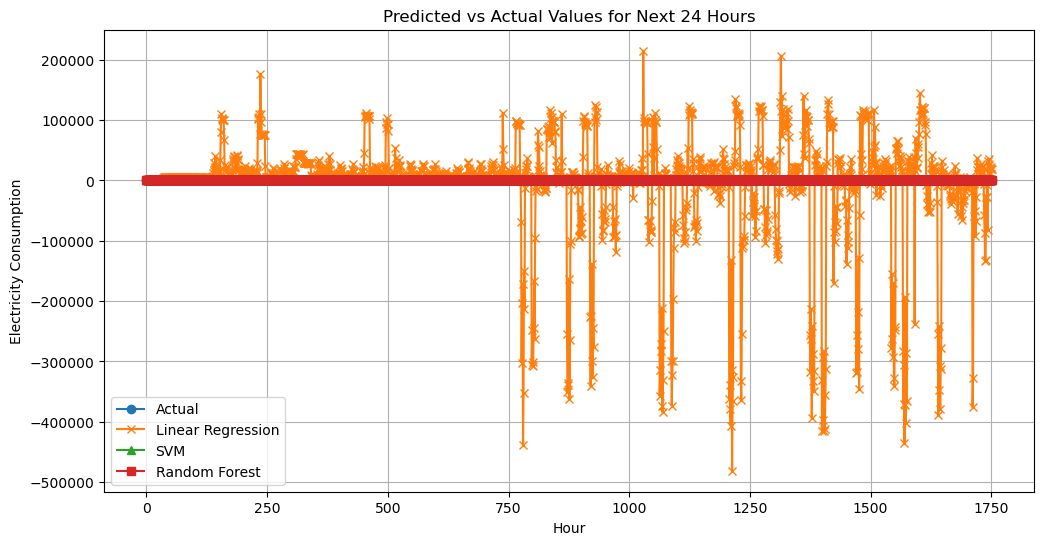

In [20]:
import matplotlib.pyplot as plt

# Train and predict with Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Add Random Forest predictions to the DataFrame
predicted_results["Random Forest"] = y_pred_rf

# Visualization: Predicted vs Actual Values for Next 24 Hours
plt.figure(figsize=(12, 6))
plt.plot(predicted_results.index, predicted_results["Actual"], label="Actual", marker="o")
plt.plot(predicted_results.index, predicted_results["Linear Regression"], label="Linear Regression", marker="x")
plt.plot(predicted_results.index, predicted_results["SVM"], label="SVM", marker="^")
plt.plot(predicted_results.index, predicted_results["Random Forest"], label="Random Forest", marker="s")

plt.title("Predicted vs Actual Values for Next 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.grid(True)
plt.show()


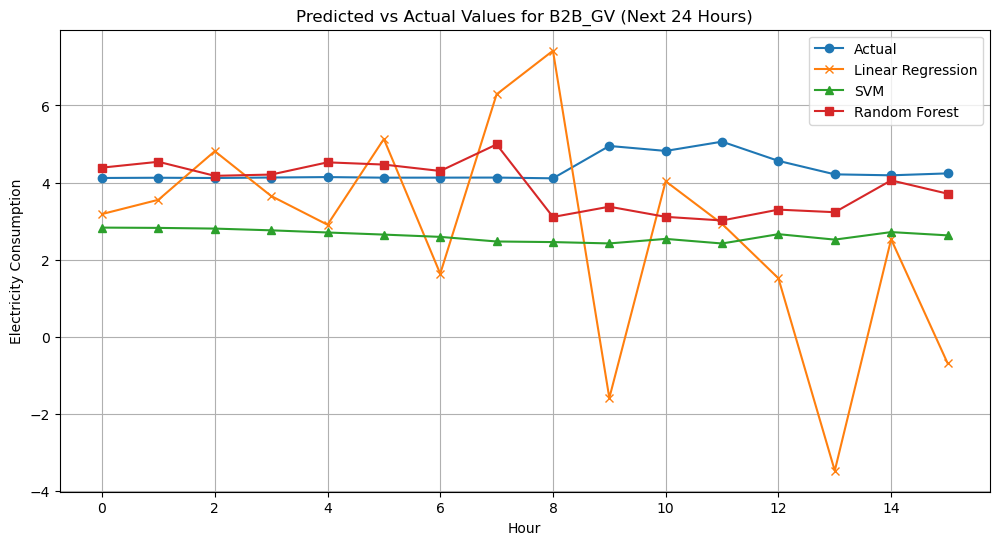

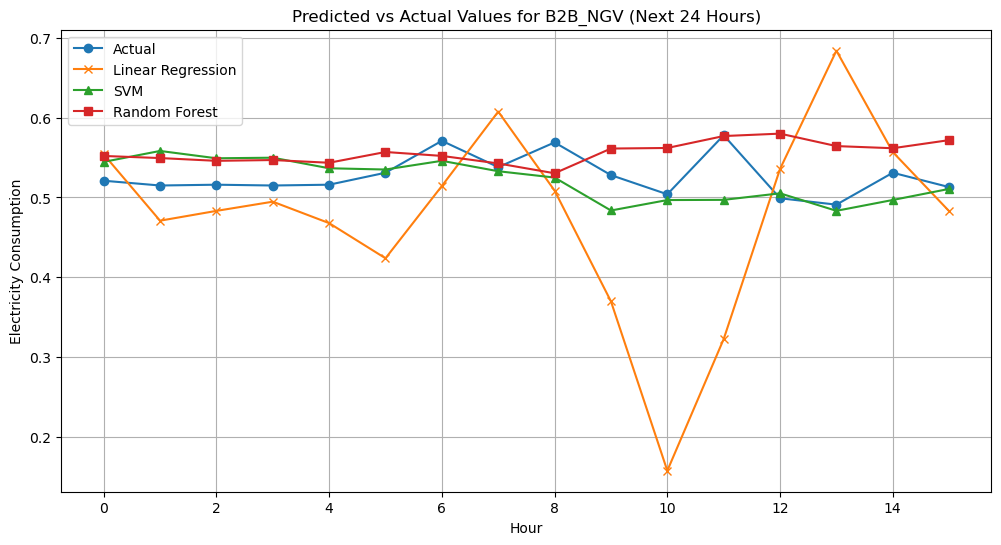

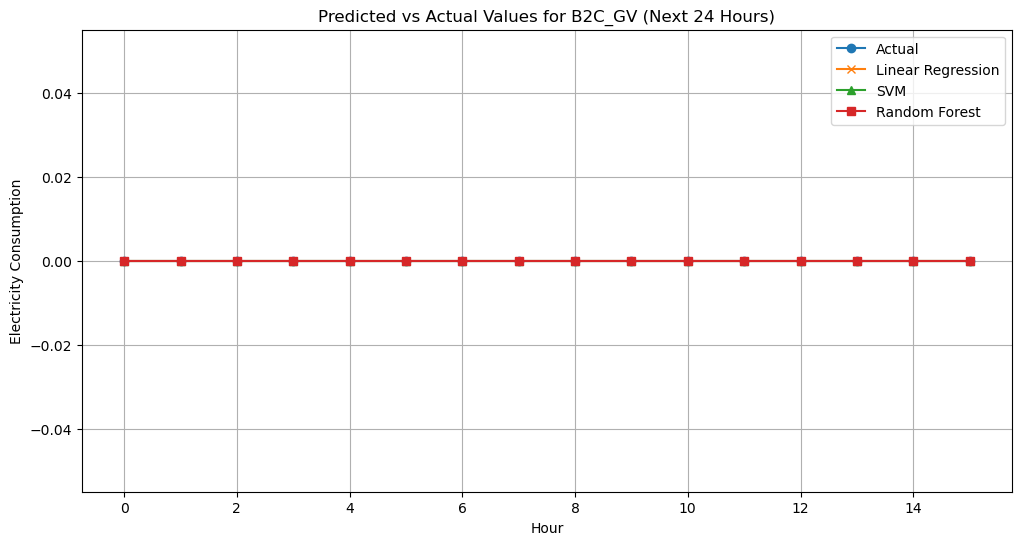

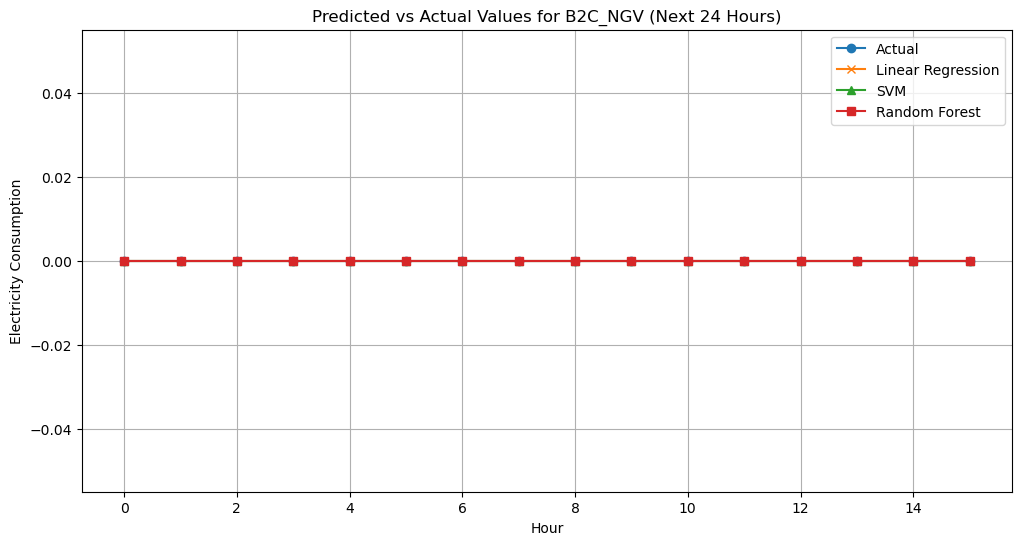

In [23]:

all_predictions = {}

# Iterate through all datasets
for dataset_name, file_path in files.items():
    
    data = pd.read_excel(file_path, nrows=1000)
    timestamp_col = "data_valanda" if "data_valanda" in data.columns else "dateTime"
    data[timestamp_col] = pd.to_datetime(data[timestamp_col])
    data['date'] = data[timestamp_col].dt.date

    # Split into train and test sets
    last_day = data['date'].iloc[-1]
    train_data = data[data['date'] < last_day].drop(columns=['date'])
    test_data = data[data['date'] == last_day].drop(columns=['date'])

    # Extract features and target
    X_train = train_data.iloc[:, 1:-1]
    y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, 1:-1]
    y_test = test_data.iloc[:, -1]

    # Store predictions
    predictions = pd.DataFrame({"Actual": y_test.reset_index(drop=True)})

    # Train and predict with all models
    for model_name, model in [
        ("Linear Regression", LinearRegression()),
        ("SVM", SVR()),
        ("Random Forest", RandomForestRegressor(random_state=42, n_estimators=50))
    ]:
        # Train and predict
        model.fit(X_train, y_train)
        predictions[model_name] = model.predict(X_test)

    # Store predictions for this dataset
    all_predictions[dataset_name] = predictions

    
    plt.figure(figsize=(12, 6))
    plt.plot(predictions.index, predictions["Actual"], label="Actual", marker="o")
    plt.plot(predictions.index, predictions["Linear Regression"], label="Linear Regression", marker="x")
    plt.plot(predictions.index, predictions["SVM"], label="SVM", marker="^")
    plt.plot(predictions.index, predictions["Random Forest"], label="Random Forest", marker="s")
    plt.title(f"Predicted vs Actual Values for {dataset_name.upper()} (Next 24 Hours)")
    plt.xlabel("Hour")
    plt.ylabel("Electricity Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()


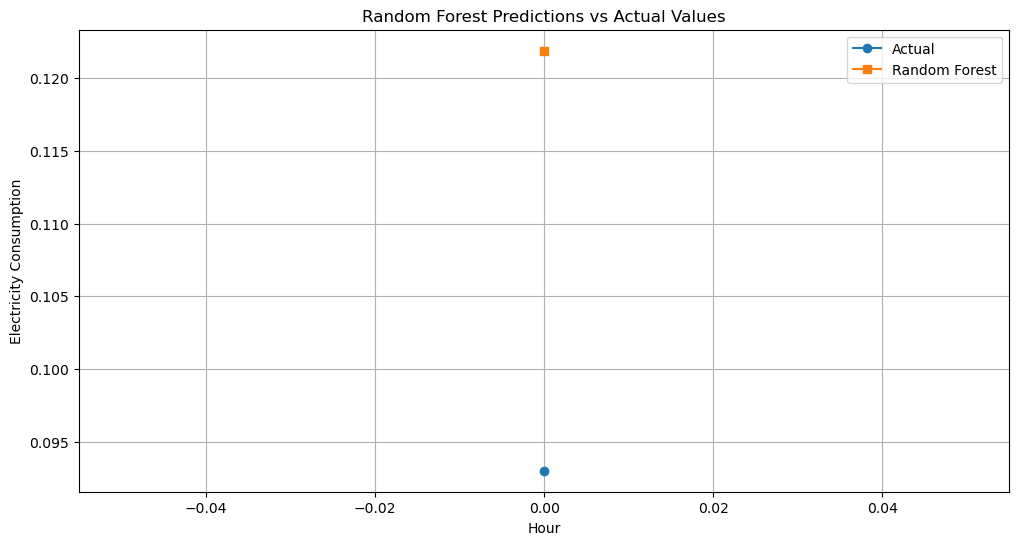

In [ ]:

b2c_gv_data = pd.read_excel(r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx")

# Confirm target column is the last unnamed numeric column
target_column = b2c_gv_data.columns[-1]

# Split dataset into train and test sets based on the last day
b2c_gv_data["dateTime"] = pd.to_datetime(b2c_gv_data["dateTime"])
b2c_gv_data["date"] = b2c_gv_data["dateTime"].dt.date
last_day = b2c_gv_data["date"].iloc[-1]

train_data = b2c_gv_data[b2c_gv_data["date"] < last_day].drop(columns=["date", "dateTime"])
test_data = b2c_gv_data[b2c_gv_data["date"] == last_day].drop(columns=["date", "dateTime"])

# Extract features and correct target column
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

# Remove constant features
non_constant_features = X_train.columns[X_train.std() > 0]
X_train = X_train[non_constant_features]
X_test = X_test[non_constant_features]


rf_model = RandomForestRegressor(random_state=42, n_estimators=50)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

# Compare predictions with actual values
predictions = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Random Forest": y_pred
})


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(predictions.index, predictions["Actual"], label="Actual", marker="o")
plt.plot(predictions.index, predictions["Random Forest"], label="Random Forest", marker="s")
plt.title("Random Forest Predictions vs Actual Values")
plt.xlabel("Hour")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
file_paths = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx",
    "interval_data": r"C:\Users\Batia\Downloads\interval_data(3).csv",
}


b2c_gv_data_sample = pd.read_excel(file_paths["b2c_gv"])
b2b_ngv_data_sample = pd.read_excel(file_paths["b2b_ngv"])
b2b_gv_data_sample = pd.read_excel(file_paths["b2b_gv"])
b2c_ngv_data_sample = pd.read_excel(file_paths["b2c_ngv"])
interval_data_sample = pd.read_csv(file_paths["interval_data"])

b2c_gv_data_sample = b2c_gv_data_sample.add_prefix("b2c_gv_")
b2b_ngv_data_sample = b2b_ngv_data_sample.add_prefix("b2b_ngv_")
b2b_gv_data_sample = b2b_gv_data_sample.add_prefix("b2b_gv_")
b2c_ngv_data_sample = b2c_ngv_data_sample.add_prefix("b2c_ngv_")
interval_data_sample = interval_data_sample.add_prefix("interval_")


for df in [b2c_gv_data_sample, b2b_ngv_data_sample, b2b_gv_data_sample, b2c_ngv_data_sample, interval_data_sample]:
    df.rename(columns={col: col.replace("timestamp_", "timestamp") for col in df.columns if "timestamp" in col}, inplace=True)



# Standardize timestamp columns for alignment
# Rename timestamp columns for clarity
# Rename timestamp columns
b2c_gv_data_sample.rename(columns={"b2c_gv_dateTime": "timestamp"}, inplace=True)
b2b_ngv_data_sample.rename(columns={"b2b_ngv_data_valanda": "timestamp"}, inplace=True)
b2b_gv_data_sample.rename(columns={"b2b_gv_data_valanda": "timestamp"}, inplace=True)
b2c_ngv_data_sample.rename(columns={"b2c_ngv_dateTime": "timestamp"}, inplace=True)
interval_data_sample.rename(columns={"interval_obs_time_utc": "timestamp"}, inplace=True)

# Convert timestamps to datetime format
for df in [b2c_gv_data_sample, b2b_ngv_data_sample, b2b_gv_data_sample, b2c_ngv_data_sample, interval_data_sample]:
    df["timestamp"] = pd.to_datetime(df["timestamp"])



for df_name, df in [("b2c_gv", b2c_gv_data_sample),
                    ("b2b_ngv", b2b_ngv_data_sample),
                    ("b2b_gv", b2b_gv_data_sample),
                    ("b2c_ngv", b2c_ngv_data_sample),
                    ("interval", interval_data_sample)]:
    if "timestamp" not in df.columns:
        print(f"'timestamp' column not found in {df_name}")
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"])

# Convert timestamps to datetime format
b2c_gv_data_sample['timestamp'] = pd.to_datetime(b2c_gv_data_sample['timestamp'])
b2b_ngv_data_sample['timestamp'] = pd.to_datetime(b2b_ngv_data_sample['timestamp'])
b2b_gv_data_sample['timestamp'] = pd.to_datetime(b2b_gv_data_sample['timestamp'])
b2c_ngv_data_sample['timestamp'] = pd.to_datetime(b2c_ngv_data_sample['timestamp'])
interval_data_sample['timestamp'] = pd.to_datetime(interval_data_sample['timestamp'])

# Align datasets by timestamp using an inner join (intersection of timestamps)
merged_data = pd.merge(interval_data_sample, b2c_gv_data_sample, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2b_ngv_data_sample, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2b_gv_data_sample, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2c_ngv_data_sample, on="timestamp", how="inner")

# Display the structure of the aligned dataset
merged_data.head()


,timestamp,interval_air_temperature,interval_feels_like_temperature,interval_wind_speed,interval_wind_gust,interval_wind_direction,interval_cloud_cover,interval_sea_level_pressure,interval_relative_humidity,interval_precipitation,...,b2c_ngv_1016,b2c_ngv_1017,b2c_ngv_1018,b2c_ngv_1019,b2c_ngv_1020,b2c_ngv_1021,b2c_ngv_1022,b2c_ngv_1023,b2c_ngv_1024,b2c_ngv_1025
0,2023-10-14 00:00:00,14.1,14.1,5.2,10.7,181,100,1004.6,88,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-10-14 01:00:00,15.0,15.0,4.5,9.0,188,88,1004.1,86,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-10-14 02:00:00,15.2,15.2,4.9,8.9,191,88,1003.9,86,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-10-14 03:00:00,15.2,15.2,4.3,9.1,192,88,1003.9,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-10-14 04:00:00,15.0,15.0,4.0,7.9,188,88,1003.1,91,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
merged_data.to_csv("merged_data.csv", index=False)

In [29]:
print("b2c_gv_data_sample columns:", b2c_gv_data_sample.columns)
print("b2b_ngv_data_sample columns:", b2b_ngv_data_sample.columns)
print("b2b_gv_data_sample columns:", b2b_gv_data_sample.columns)
print("b2c_ngv_data_sample columns:", b2c_ngv_data_sample.columns)
print("interval_data_sample columns:", interval_data_sample.columns)

b2c_gv_data_sample columns: Index(['b2c_gv_dateTime', 'b2c_gv_0', 'b2c_gv_1', 'b2c_gv_2', 'b2c_gv_3',
       'b2c_gv_4', 'b2c_gv_5', 'b2c_gv_6', 'b2c_gv_7', 'b2c_gv_8',
       ...
       'b2c_gv_1040', 'b2c_gv_1041', 'b2c_gv_1042', 'b2c_gv_1043',
       'b2c_gv_1044', 'b2c_gv_1045', 'b2c_gv_1046', 'b2c_gv_1047',
       'b2c_gv_1048', 'b2c_gv_1049'],
      dtype='object', length=1051)
b2b_ngv_data_sample columns: Index(['b2b_ngv_data_valanda', 'b2b_ngv_0', 'b2b_ngv_1', 'b2b_ngv_2',
       'b2b_ngv_3', 'b2b_ngv_4', 'b2b_ngv_5', 'b2b_ngv_6', 'b2b_ngv_7',
       'b2b_ngv_8',
       ...
       'b2b_ngv_789', 'b2b_ngv_790', 'b2b_ngv_791', 'b2b_ngv_792',
       'b2b_ngv_793', 'b2b_ngv_794', 'b2b_ngv_795', 'b2b_ngv_796',
       'b2b_ngv_797', 'b2b_ngv_798'],
      dtype='object', length=800)
b2b_gv_data_sample columns: Index(['b2b_gv_data_valanda', 'b2b_gv_0', 'b2b_gv_1', 'b2b_gv_2', 'b2b_gv_3',
       'b2b_gv_4', 'b2b_gv_5', 'b2b_gv_6', 'b2b_gv_7', 'b2b_gv_8',
       ...
       'b2b_gv_753', 

In [30]:
print("interval_data_sample columns:", interval_data_sample.columns)

interval_data_sample columns: Index(['interval_obs_time_utc', 'interval_air_temperature',
       'interval_feels_like_temperature', 'interval_wind_speed',
       'interval_wind_gust', 'interval_wind_direction', 'interval_cloud_cover',
       'interval_sea_level_pressure', 'interval_relative_humidity',
       'interval_precipitation', 'interval_condition_code'],
      dtype='object')


In [36]:
# Reload the original files
file_paths = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx",
    "interval_data": r"C:\Users\Batia\Downloads\interval_data(3).csv",
}

# Load the datasets
b2c_gv_data = pd.read_excel(file_paths["b2c_gv"])
b2b_ngv_data = pd.read_excel(file_paths["b2b_ngv"])
b2b_gv_data = pd.read_excel(file_paths["b2b_gv"])
b2c_ngv_data = pd.read_excel(file_paths["b2c_ngv"])
interval_data = pd.read_csv(file_paths["interval_data"])

# Add prefixes to column names for clarity
b2c_gv_data = b2c_gv_data.add_prefix("b2c_gv_")
b2b_ngv_data = b2b_ngv_data.add_prefix("b2b_ngv_")
b2b_gv_data = b2b_gv_data.add_prefix("b2b_gv_")
b2c_ngv_data = b2c_ngv_data.add_prefix("b2c_ngv_")
interval_data = interval_data.add_prefix("interval_")

# Standardize timestamp column names
b2c_gv_data.rename(columns={"b2c_gv_dateTime": "timestamp"}, inplace=True)
b2b_ngv_data.rename(columns={"b2b_ngv_data_valanda": "timestamp"}, inplace=True)
b2b_gv_data.rename(columns={"b2b_gv_data_valanda": "timestamp"}, inplace=True)
b2c_ngv_data.rename(columns={"b2c_ngv_dateTime": "timestamp"}, inplace=True)
interval_data.rename(columns={"interval_obs_time_utc": "timestamp"}, inplace=True)

# Convert timestamps to datetime format
datasets = [b2c_gv_data, b2b_ngv_data, b2b_gv_data, b2c_ngv_data, interval_data]
for df in datasets:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter data for the range August 1, 2023 - October 13, 2023
start_date = pd.Timestamp("2023-08-01")
end_date = pd.Timestamp("2023-10-13")

for df in datasets:
    df = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

# Merge datasets on timestamp
merged_data = pd.merge(interval_data, b2c_gv_data, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2b_ngv_data, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2b_gv_data, on="timestamp", how="inner")
merged_data = pd.merge(merged_data, b2c_ngv_data, on="timestamp", how="inner")

# Save the final merged dataset for modeling
merged_data_path = r"C:\Users\Batia\Downloads\merged_data_full.csv"
merged_data.to_csv(merged_data_path, index=False)

# Display the first few rows of the merged dataset
# import ace_tools as tools; tools.display_dataframe_to_user(name="Merged Data (Full Date Range)", dataframe=merged_data)


In [38]:
# Reload necessary libraries and retry merging
import pandas as pd

# Define the file paths again
file_paths = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx",
    "interval_data": r"C:\Users\Batia\Downloads\interval_data(3).csv",
}

# Reload datasets
b2c_gv = pd.read_excel(file_paths["b2c_gv"])
b2b_ngv = pd.read_excel(file_paths["b2b_ngv"])
b2b_gv = pd.read_excel(file_paths["b2b_gv"])
b2c_ngv = pd.read_excel(file_paths["b2c_ngv"])
interval_data = pd.read_csv(file_paths["interval_data"])

# Add prefixes to column names for clarity
b2c_gv_data = b2c_gv_data.add_prefix("b2c_gv_")
b2b_ngv_data = b2b_ngv_data.add_prefix("b2b_ngv_")
b2b_gv_data = b2b_gv_data.add_prefix("b2b_gv_")
b2c_ngv_data = b2c_ngv_data.add_prefix("b2c_ngv_")
interval_data = interval_data.add_prefix("interval_")

# Standardize timestamp column names
b2c_gv_data.rename(columns={"b2c_gv_dateTime": "timestamp"}, inplace=True)
b2b_ngv_data.rename(columns={"b2b_ngv_data_valanda": "timestamp"}, inplace=True)
b2b_gv_data.rename(columns={"b2b_gv_data_valanda": "timestamp"}, inplace=True)
b2c_ngv_data.rename(columns={"b2c_ngv_dateTime": "timestamp"}, inplace=True)
interval_data.rename(columns={"interval_obs_time_utc": "timestamp"}, inplace=True)

# Convert timestamps to datetime
datasets = [b2c_gv, b2b_ngv, b2b_gv, b2c_ngv, interval_data]
for df in datasets:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter datasets for August 1, 2023, to October 13, 2023
start_date = pd.Timestamp("2023-08-01")
end_date = pd.Timestamp("2023-10-13")

filtered_datasets = []
for df in datasets:
    filtered_datasets.append(df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)])

# Unpack the filtered datasets
b2c_gv, b2b_ngv, b2b_gv, b2c_ngv, interval_data = filtered_datasets

# Merge datasets sequentially
merged_data = interval_data.copy()
for df in [b2c_gv, b2b_ngv, b2b_gv, b2c_ngv]:
    merged_data = pd.merge(merged_data, df, on="timestamp", how="inner")

# Save the new merged dataset
merged_data_path = r"C:\Users\Batia\Downloads\merged_data_full_range.csv"
merged_data.to_csv(merged_data_path, index=False)

# Display the merged dataset to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Merged Data (August to October 2023)", dataframe=merged_data)


KeyError: 'timestamp'

In [39]:
# Reload datasets and ensure proper column renaming
file_paths = {
    "b2b_gv": r"C:\Users\Batia\Downloads\b2b_gv_vartojimas.xlsx\b2b_gv_vartojimas.xlsx",
    "b2b_ngv": r"C:\Users\Batia\Downloads\b2b_ngv_vartojimas.xlsx\b2b_ngv_vartojimas.xlsx",
    "b2c_gv": r"C:\Users\Batia\Downloads\b2c_gv_vartojimas.xlsx\b2c_gv_vartojimas.xlsx",
    "b2c_ngv": r"C:\Users\Batia\Downloads\b2c_ngv_vartojimas.xlsx\b2c_ngv_vartojimas.xlsx",
    "interval_data": r"C:\Users\Batia\Downloads\interval_data(3).csv",
}

# Reload datasets with column renaming
datasets_info = {
    "b2c_gv": {"path": file_paths["b2c_gv"], "timestamp_col": "dateTime", "prefix": "b2c_gv_"},
    "b2b_ngv": {"path": file_paths["b2b_ngv"], "timestamp_col": "data_valanda", "prefix": "b2b_ngv_"},
    "b2b_gv": {"path": file_paths["b2b_gv"], "timestamp_col": "data_valanda", "prefix": "b2b_gv_"},
    "b2c_ngv": {"path": file_paths["b2c_ngv"], "timestamp_col": "dateTime", "prefix": "b2c_ngv_"},
    "interval_data": {"path": file_paths["interval_data"], "timestamp_col": "obs_time_utc", "prefix": "interval_"}
}

# Process datasets to ensure timestamps are standardized and add prefixes
processed_datasets = {}
for name, info in datasets_info.items():
    if name == "interval_data":
        df = pd.read_csv(info["path"])
    else:
        df = pd.read_excel(info["path"])
    # Rename timestamp column and add prefix
    df.rename(columns={info["timestamp_col"]: "timestamp"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.add_prefix(info["prefix"])
    df.rename(columns={f"{info['prefix']}timestamp": "timestamp"}, inplace=True)
    processed_datasets[name] = df

# Filter data for the date range
start_date = "2023-08-01"
end_date = "2023-10-13"

for name, df in processed_datasets.items():
    processed_datasets[name] = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

# Merge datasets incrementally
merged_data = processed_datasets["interval_data"]
for name, df in processed_datasets.items():
    if name != "interval_data":
        merged_data = pd.merge(merged_data, df, on="timestamp", how="inner")

# Save the final merged dataset
merged_data_path = r"C:\Users\Batia\Downloads\merged_data_final.csv"
merged_data.to_csv(merged_data_path, index=False)

# Display the structure of the final merged dataset
# import ace_tools as tools; tools.display_dataframe_to_user(name="Final Merged Data", dataframe=merged_data)
